# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias_db = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep = ";")


In [3]:
# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep = ";")

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias_db.shape


(891221, 85)

In [5]:
azdias_db.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


The method .info() is great for checking out the data types of the different features.

In [6]:
azdias_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

The describe() function is used to generate descriptive statistics that summarize the central tendency, dispersion and shape of a dataset's distribution, excluding NaN values

In [7]:
azdias_db.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


### Summary of feature attributes for demographics data

In [8]:
feat_info.shape

(85, 4)

In [9]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [10]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!



## Missing data in the original Data set prior Data Cleaning

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.



The number of missing values per variable in the original Dataset can be seen in the following output:

In [12]:
azdias_db.isnull().sum().sort_values(ascending=False)


KK_KUNDENTYP             584612
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
KBA05_ANTG4              133324
KBA05_BAUMAX             133324
KBA05_GBZ                133324
MOBI_REGIO               133324
REGIOTYP                 121196
KKK                      121196
PLZ8_ANTG3               116515
PLZ8_ANTG1               116515
PLZ8_GBZ                 116515
PLZ8_ANTG2               116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
W_KEIT_KIND_HH           107602
KBA13_ANZAHL_PKW         105800
CAMEO_INTL_2015           98979
CAMEO_DEU_2015            98979
CAMEO_DEUG_2015           98979
ORTSGR_KLS9               97216
ARBEIT                    97216
RELAT_AB                  97216
ANZ_HH_TITEL              97008
BALLRAUM                  93740
EWDICHTE                  93740
INNENSTADT                93740
GEBAEUDETYP_RASTER        93155
                          ...  
FINANZ_H

In [13]:
# Investigate patterns in the amount of missing data in each column.



The percentages of missing values per variable can be seen in the following output, expressed as decimals:

In [14]:
nans_eachc = (azdias_db.isnull().mean() * 100).sort_values(ascending=False)
nans_eachc[:25]

KK_KUNDENTYP        65.596749
KBA05_ANTG1         14.959701
KBA05_ANTG2         14.959701
KBA05_ANTG3         14.959701
KBA05_ANTG4         14.959701
KBA05_BAUMAX        14.959701
KBA05_GBZ           14.959701
MOBI_REGIO          14.959701
REGIOTYP            13.598872
KKK                 13.598872
PLZ8_ANTG3          13.073637
PLZ8_ANTG1          13.073637
PLZ8_GBZ            13.073637
PLZ8_ANTG2          13.073637
PLZ8_HHZ            13.073637
PLZ8_BAUMAX         13.073637
PLZ8_ANTG4          13.073637
W_KEIT_KIND_HH      12.073549
KBA13_ANZAHL_PKW    11.871354
CAMEO_INTL_2015     11.106000
CAMEO_DEU_2015      11.106000
CAMEO_DEUG_2015     11.106000
ORTSGR_KLS9         10.908181
ARBEIT              10.908181
RELAT_AB            10.908181
dtype: float64

The column KK_KUNDENTYP has the highest percentage of missing values (65%)
the next columns KBA05_ANTG1, KBA05_ANTG2, KBA05_ANTG3, KBA05_ANTG4, KBA05_BAUMAX, KBA05_GBZ, MOBI_REGIO  have the percentage of missing values at 14.9% 

## Let's make a bar plot with the percentage of missing values per variable in the original Dataset:

Text(0.5,1,'Quantifying missing data')

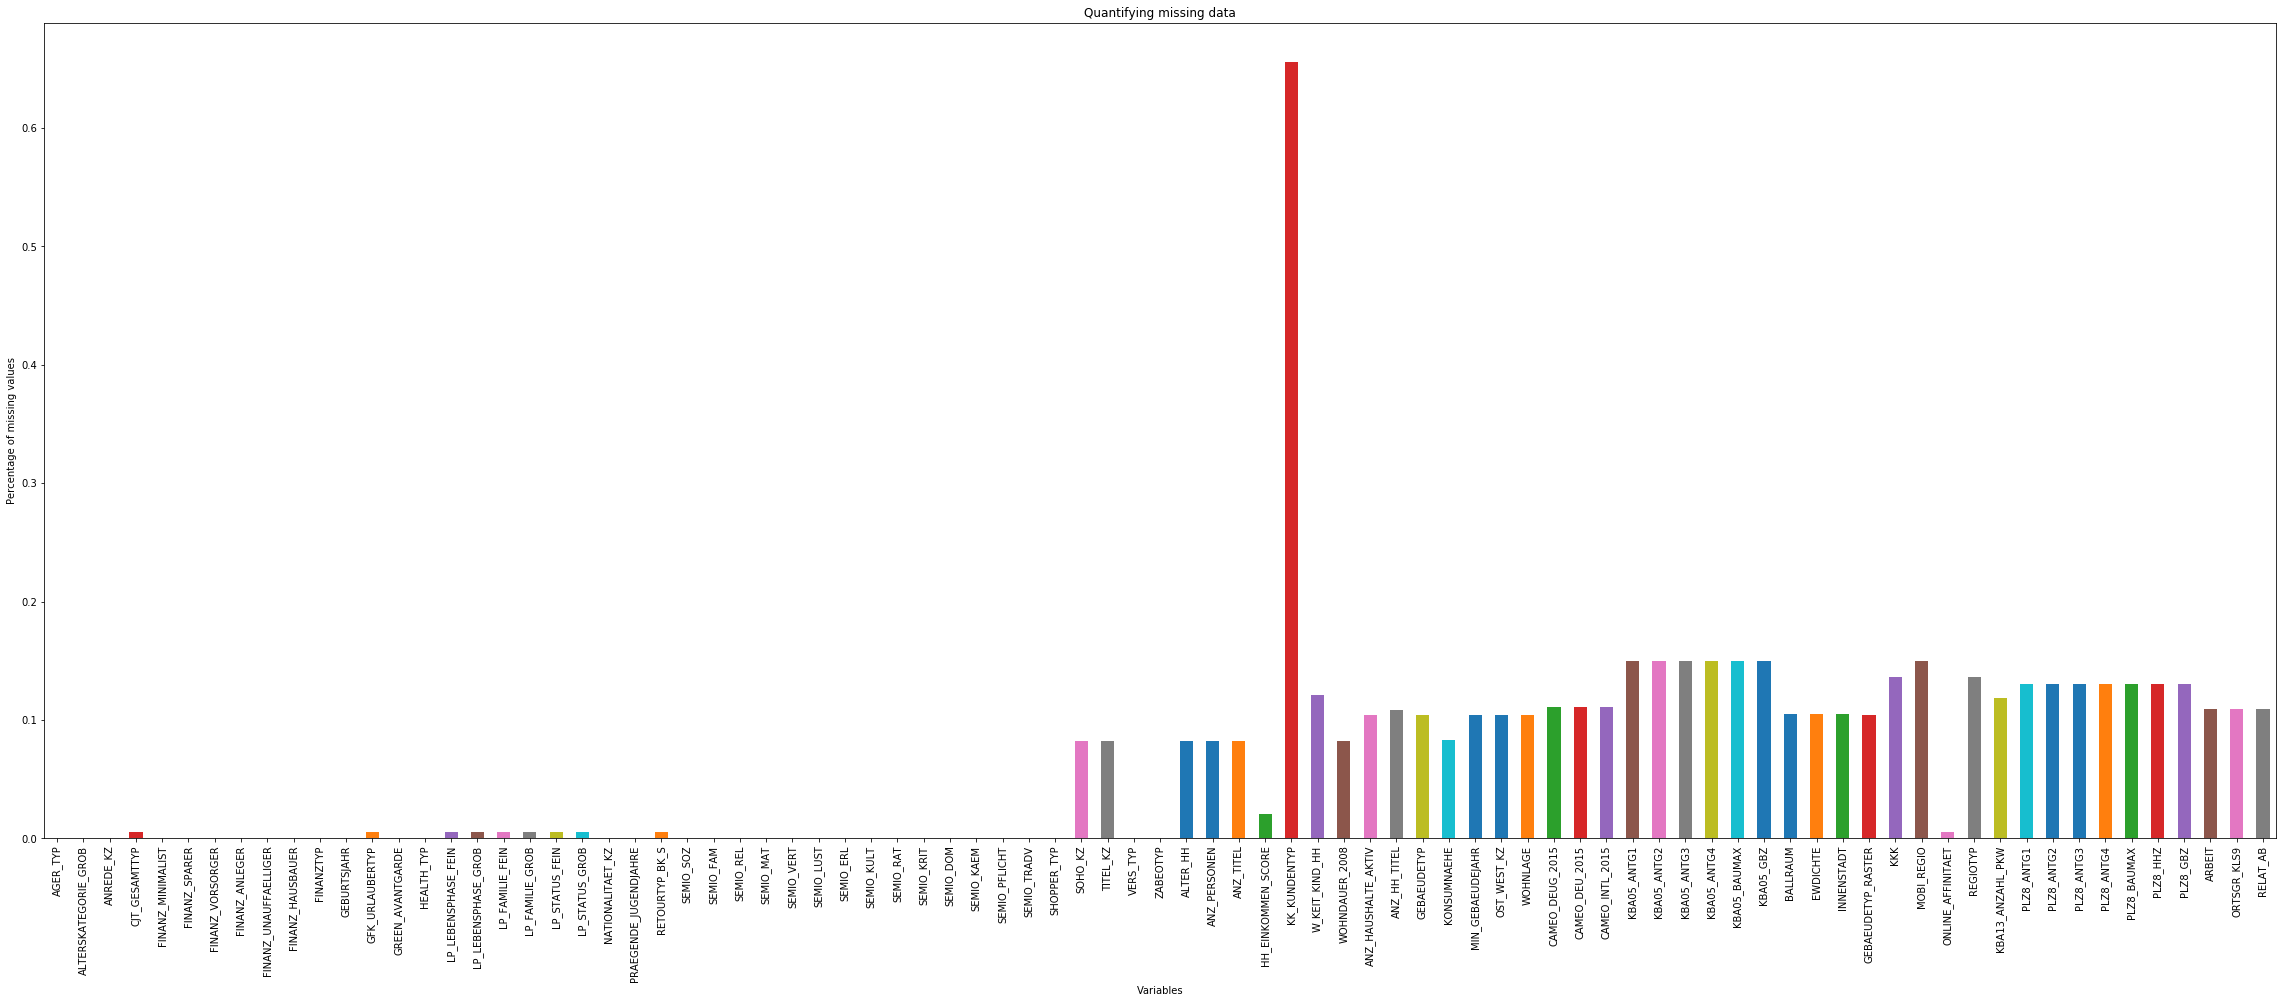

In [15]:
azdias_db.isnull().mean().plot.bar(figsize=(40,15))
plt.ylabel('Percentage of missing values')
plt.xlabel('Variables')
plt.title('Quantifying missing data')

In [16]:
## How much data is missing in each column of the original dataset?

In [17]:
# TOTAL number of missing values:
azdias_db.isnull().sum().sum()

4896838

In [18]:
# number of COLUMNS with at least one missing value:
(azdias_db.isnull().sum(axis=0) > 0).sum()

53

In [19]:
np.product(azdias_db.shape) * 100

7575378500

In [20]:
# How many nans before processing?
print('Total percentage of Nans before processing: ',
      round(azdias_db.isnull().sum().sum() / np.product(azdias_db.shape) * 100, 2),
      '%')

Total percentage of Nans before processing:  6.46 %


The column KK_KUNDENTYP has the highest percentage of missing values (65%) should be revoved from de data set

 ## Convert missing values to NaNs.


#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [21]:
feature_info_new = feat_info
feature_info_new['new_NaNs_status'] = feat_info['missing_or_unknown']
feature_info_new['new_NaNs_status'] = feat_info['new_NaNs_status'].str.replace('[','')
feature_info_new['new_NaNs_status'] = feat_info['new_NaNs_status'].str.replace(']','')

In [22]:
feature_info_new.head(10)

,attribute,information_level,type,missing_or_unknown,new_NaNs_status
0,AGER_TYP,person,categorical,"[-1,0]","-1,0"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","-1,0,9"
2,ANREDE_KZ,person,categorical,"[-1,0]","-1,0"
3,CJT_GESAMTTYP,person,categorical,[0],0
4,FINANZ_MINIMALIST,person,ordinal,[-1],-1
5,FINANZ_SPARER,person,ordinal,[-1],-1
6,FINANZ_VORSORGER,person,ordinal,[-1],-1
7,FINANZ_ANLEGER,person,ordinal,[-1],-1
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1],-1
9,FINANZ_HAUSBAUER,person,ordinal,[-1],-1


In [23]:
azdias_db_new = azdias_db
for column in range(azdias_db.shape[1]):
    feature_column_4 = feature_info_new.iloc[column,4]
    feature_column_4 = feature_column_4.split(sep=',')
    feature_column_4 = [int(value) if (value != 'X' and value != 'XX' and value != '') else value for value in feature_column_4]
    if feature_column_4 != ['']:
        azdias_db_new = azdias_db_new.replace({feature_info_new.iloc[column]['attribute']: feature_column_4}, np.nan)

In [24]:
azdias_db_new.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [25]:
# TOTAL number of missing values after conversion:

In [26]:
azdias_db_new.isna().sum().sum()

8373929

*** The amount of missing values are almost doble after the conversion

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [27]:
azdias_db_NaNs_count = (azdias_db_new.isnull().mean() * 100).sort_values(ascending=False)
azdias_db_NaNs_count[:15]

TITEL_KZ          99.757636
AGER_TYP          76.955435
KK_KUNDENTYP      65.596749
KBA05_BAUMAX      53.468668
GEBURTSJAHR       44.020282
ALTER_HH          34.813699
REGIOTYP          17.735668
KKK               17.735668
W_KEIT_KIND_HH    16.605084
KBA05_ANTG4       14.959701
KBA05_GBZ         14.959701
MOBI_REGIO        14.959701
KBA05_ANTG1       14.959701
KBA05_ANTG2       14.959701
KBA05_ANTG3       14.959701
dtype: float64

## Let's make a bar plot with the percentage of missing values per variable in the converted Dataset:

Text(0.5,1,'Quantifying missing data')

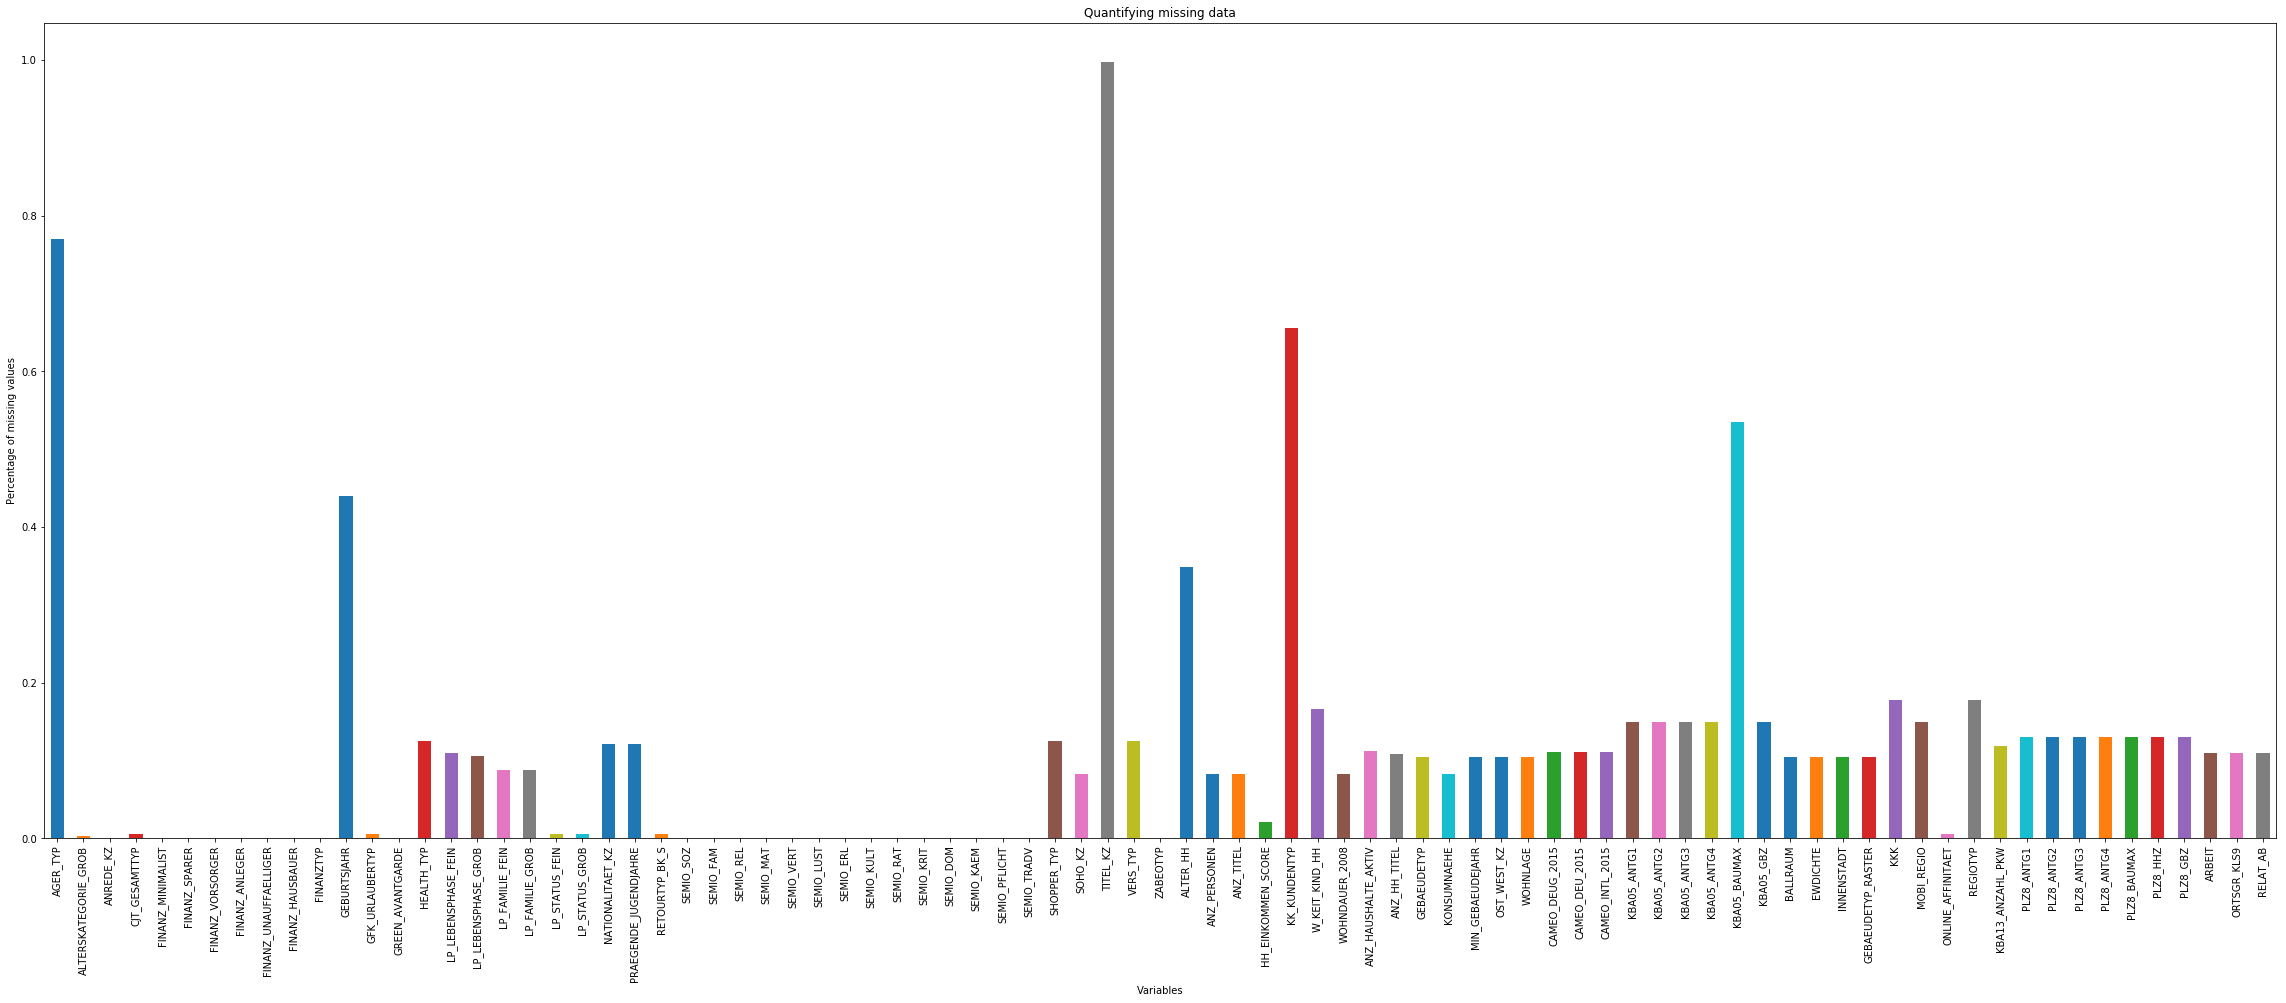

In [28]:
azdias_db_new.isnull().mean().plot.bar(figsize=(40,15))
plt.ylabel('Percentage of missing values')
plt.xlabel('Variables')
plt.title('Quantifying missing data')

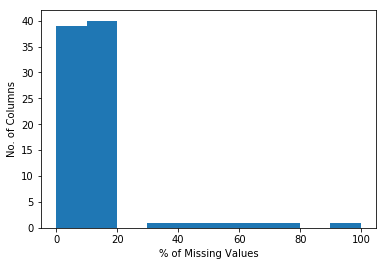

In [29]:
plt.hist(azdias_db_new.isnull().mean().sort_values(ascending=False)*100)
plt.xlabel('% of Missing Values')
plt.ylabel('No. of Columns');

In [30]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)



In [31]:
azdias_over20 = azdias_db_NaNs_count[azdias_db_NaNs_count>20]

In [32]:
azdias_over20

TITEL_KZ        99.757636
AGER_TYP        76.955435
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
GEBURTSJAHR     44.020282
ALTER_HH        34.813699
dtype: float64

In [33]:
azdias_db_new_drop = azdias_db_new
azdias_db_new_drop.drop(azdias_over20.index, axis=1, inplace=True)

In [34]:
azdias_db_new_drop.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

The column with more than 20% of missing values were removed from de data set, they were TITEL_KZ, AGER_TYP, KK_KUNDENTYP, KBA05_BAUMAX, GEBURTSJAHR and ALTER_HH 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [35]:
# How much data is missing in each row of the dataset?

In [36]:
azdias_db_NaNs_row_count = azdias_db_new_drop.isna().sum(axis=1)

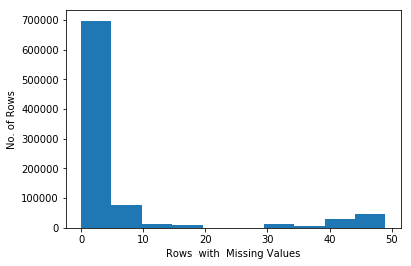

In [37]:
plt.hist(azdias_db_NaNs_row_count)
plt.xlabel('Rows  with  Missing Values')
plt.ylabel('No. of Rows');

# Write code to divide the data into two subsets based on the number of missing values in each row.



In [38]:
azdias_db_NaNs_row_below20 = azdias_db_new_drop[azdias_db_new_drop.isna().sum(axis=1)<20]
azdias_row_below20 = azdias_db_new_drop.iloc[azdias_db_NaNs_row_below20.index,:]


In [39]:
azdias_db_NaNs_row_over20 = azdias_db_new_drop[azdias_db_new_drop.isna().sum(axis=1)>=20]
azdias_row_over20 = azdias_db_new_drop.iloc[azdias_db_NaNs_row_over20.index,:]

# Compare the distribution of values for at least five columns where there are no or few missing values, between the two subsets.



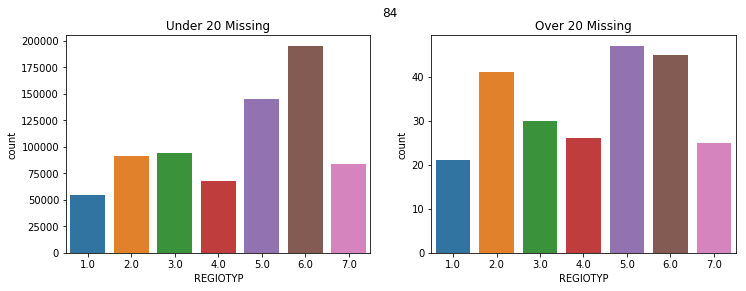

In [40]:

fig = plt.figure(14, figsize=(12,4))

ax1 = fig.add_subplot(121)
ax1.title.set_text('Under 20 Missing')
sns.countplot(azdias_row_below20['REGIOTYP'])
fig.suptitle(column);           

ax2 = fig.add_subplot(122)
ax2.title.set_text('Over 20 Missing')
sns.countplot(azdias_row_over20['REGIOTYP'])
             
fig.suptitle(column);

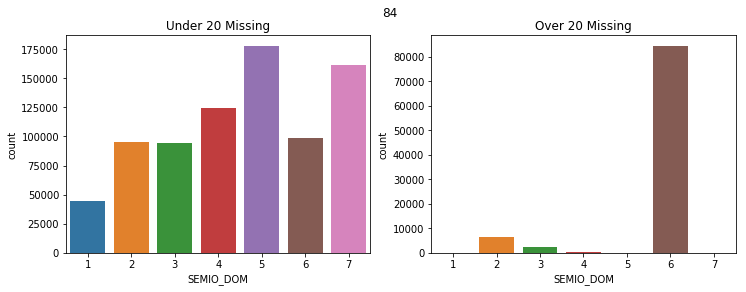

In [41]:

fig = plt.figure(14, figsize=(12,4))

ax1 = fig.add_subplot(121)
ax1.title.set_text('Under 20 Missing')
sns.countplot(azdias_row_below20['SEMIO_DOM'])
fig.suptitle(column);           

ax2 = fig.add_subplot(122)
ax2.title.set_text('Over 20 Missing')
sns.countplot(azdias_row_over20['SEMIO_DOM'])
             
fig.suptitle(column);

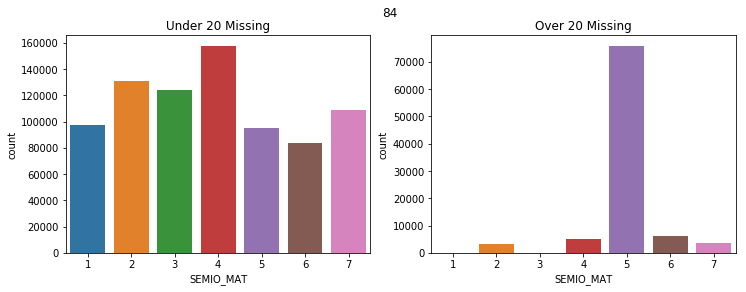

In [42]:

fig = plt.figure(14, figsize=(12,4))

ax1 = fig.add_subplot(121)
ax1.title.set_text('Under 20 Missing')
sns.countplot(azdias_row_below20['SEMIO_MAT'])
fig.suptitle(column);           

ax2 = fig.add_subplot(122)
ax2.title.set_text('Over 20 Missing')
sns.countplot(azdias_row_over20['SEMIO_MAT'])
             
fig.suptitle(column);

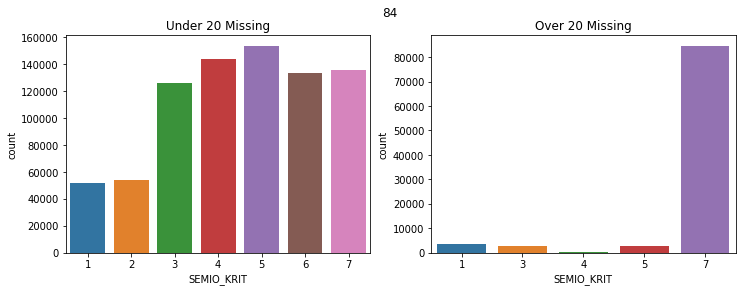

In [43]:

fig = plt.figure(14, figsize=(12,4))

ax1 = fig.add_subplot(121)
ax1.title.set_text('Under 20 Missing')
sns.countplot(azdias_row_below20['SEMIO_KRIT'])
fig.suptitle(column);           

ax2 = fig.add_subplot(122)
ax2.title.set_text('Over 20 Missing')
sns.countplot(azdias_row_over20['SEMIO_KRIT'])
             
fig.suptitle(column);

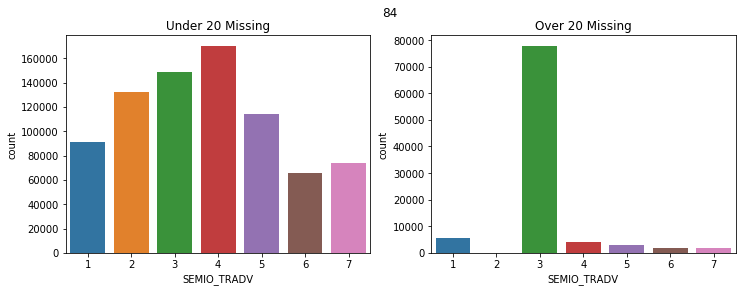

In [44]:

fig = plt.figure(14, figsize=(12,4))

ax1 = fig.add_subplot(121)
ax1.title.set_text('Under 20 Missing')
sns.countplot(azdias_row_below20['SEMIO_TRADV'])
fig.suptitle(column);           

ax2 = fig.add_subplot(122)
ax2.title.set_text('Over 20 Missing')
sns.countplot(azdias_row_over20['SEMIO_TRADV'])
             
fig.suptitle(column);

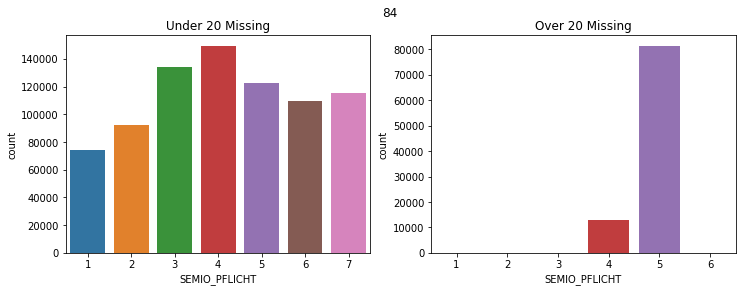

In [45]:

fig = plt.figure(14, figsize=(12,4))

ax1 = fig.add_subplot(121)
ax1.title.set_text('Under 20 Missing')
sns.countplot(azdias_row_below20['SEMIO_PFLICHT'])
fig.suptitle(column);           

ax2 = fig.add_subplot(122)
ax2.title.set_text('Over 20 Missing')
sns.countplot(azdias_row_over20['SEMIO_PFLICHT'])
             
fig.suptitle(column);

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

### Observations

### The distributions are too much different. Therefore, is so important the cleaning the data before processing the data.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

## How many features are there of each data type?

In [46]:
# How many features are there of each data type?
column_list = azdias_row_below20.columns.tolist()
column_list

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'PRAEGENDE_JUGENDJAHRE',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'GEBAEUDETYP',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'OST_WEST_KZ',
 'WOHNLAGE',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CAMEO_INTL_2015',
 'KBA05_ANTG1',
 'K

In [47]:
# How many features are there of each data type?

feat_info_new = feat_info[feat_info['attribute'].isin(column_list)]
feat_info_new.head()

,attribute,information_level,type,missing_or_unknown,new_NaNs_status
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","-1,0,9"
2,ANREDE_KZ,person,categorical,"[-1,0]","-1,0"
3,CJT_GESAMTTYP,person,categorical,[0],0
4,FINANZ_MINIMALIST,person,ordinal,[-1],-1
5,FINANZ_SPARER,person,ordinal,[-1],-1


In [48]:
# How many features are there of each data type?
feat_info_new['type'].value_counts()


ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

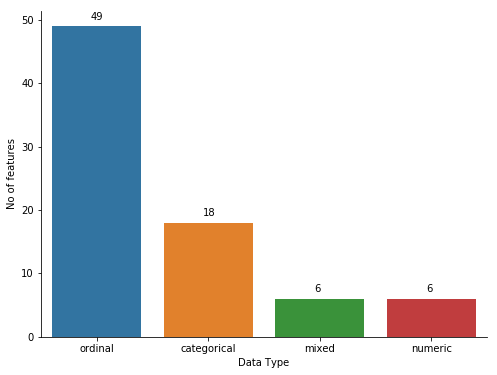

In [49]:
fig, ax1 = plt.subplots(figsize=(8,6))
sns.countplot(data=feat_info_new,
              x='type',
              ax=ax1)
ax1.set_ylabel('No of features')
ax1.set_xlabel('Data Type')
for p in ax1.patches:
    ax1.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+1))
sns.despine(ax=ax1);

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

## Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?

In [50]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?



In [51]:
# Get the categorical feature names
list_cat_column = feat_info_new[feat_info_new.type == 'categorical'].attribute
list_cat_column

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [52]:
# Find the number of Categorical levels
azdias_row_below20[list_cat_column].nunique()

ANREDE_KZ            2
CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
GREEN_AVANTGARDE     2
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     3
SHOPPER_TYP          4
SOHO_KZ              2
VERS_TYP             2
ZABEOTYP             6
GEBAEUDETYP          7
OST_WEST_KZ          2
CAMEO_DEUG_2015      9
CAMEO_DEU_2015      44
dtype: int64

In [53]:
# Find the data type of Categorical feature
azdias_row_below20[list_cat_column].dtypes

ANREDE_KZ             int64
CJT_GESAMTTYP       float64
FINANZTYP             int64
GFK_URLAUBERTYP     float64
GREEN_AVANTGARDE      int64
LP_FAMILIE_FEIN     float64
LP_FAMILIE_GROB     float64
LP_STATUS_FEIN      float64
LP_STATUS_GROB      float64
NATIONALITAET_KZ    float64
SHOPPER_TYP         float64
SOHO_KZ             float64
VERS_TYP            float64
ZABEOTYP              int64
GEBAEUDETYP         float64
OST_WEST_KZ          object
CAMEO_DEUG_2015      object
CAMEO_DEU_2015       object
dtype: object

In [54]:
# how many binary
sum(azdias_row_below20[list_cat_column].nunique() == 2)

5

In [55]:
list_binary_column = []

In [56]:
for i in azdias_row_below20[list_cat_column]:
    if  azdias_row_below20[i].nunique() == 2:
        list_binary_column.append(i)

In [57]:
list_binary_column

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [58]:
# Find the data type of Categorical binary feature
azdias_row_below20[list_binary_column].dtypes

ANREDE_KZ             int64
GREEN_AVANTGARDE      int64
SOHO_KZ             float64
VERS_TYP            float64
OST_WEST_KZ          object
dtype: object

### Those column have two posible value but neet to be converted to be proces by the model

In [59]:
# how many multilevel caterorical feature
sum(azdias_row_below20[list_cat_column].nunique() != 2)

13

In [60]:
list_multi_level_column = []

In [61]:
for i in azdias_row_below20[list_cat_column]:
    if  azdias_row_below20[i].nunique() != 2:
        list_multi_level_column.append(i)

In [62]:
 list_multi_level_column

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [63]:
azdias_new = azdias_row_below20.drop(list_multi_level_column, axis = 1)

In [64]:
azdias_new.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,1,5,2,5,4,5,0,3.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [65]:
# Get the mixed feature names
list_mix_column = feat_info_new[feat_info_new.type == 'mixed'].attribute
list_mix_column

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [66]:
# Find the number of mixed feature
azdias_row_below20[list_mix_column].nunique()

LP_LEBENSPHASE_FEIN      40
LP_LEBENSPHASE_GROB      12
PRAEGENDE_JUGENDJAHRE    15
WOHNLAGE                  8
CAMEO_INTL_2015          21
PLZ8_BAUMAX               5
dtype: int64

In [67]:
# Find the dat type of mixed feature
azdias_row_below20[list_mix_column].dtypes

LP_LEBENSPHASE_FEIN      float64
LP_LEBENSPHASE_GROB      float64
PRAEGENDE_JUGENDJAHRE    float64
WOHNLAGE                 float64
CAMEO_INTL_2015           object
PLZ8_BAUMAX              float64
dtype: object

In [68]:
# Re-encode categorical variable(s) to be kept in the analysis.



#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

### I will keep the 5 binary feature and  I will drop the multi-level categoricals features from the analysis

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)
    
    


New Variables Data encoding:

PRAEGENDE_ENG_DECADE:

Person’s decade of youth.

1: 40
2: 40
3: 50
4: 50
5: 60
6: 60
7: 60
8: 70
9: 70
10: 80
11: 80
12: 80
13: 80
14: 90
15: 90



    PRAEGENDE_ENG_MOVEMENT:

Person’s movement alignment.


1: Mainstream
2: Avantgarde
3: Mainstream
4: Avantgarde
5: Mainstream
6: Avantgarde
7: Avantgarde
8: Mainstream
9: Avantgarde
10: Mainstream
11: Avantgarde
12: Mainstream
13: Avantgarde
14: Mainstream
15: Avantgarde

New encooding


0: Avantgarde
1: Mainstream

In [69]:
decade_dict = {1: 40, 2: 40, 3: 50, 4:50, 5: 60, 6: 60, 7:  60,
               8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80,
               14: 90, 15: 90,np.nan : np.nan
              }
movement_dict = {1: 1, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0,
                8: 1, 9: 0, 10: 1, 11: 0, 12: 1, 13: 0, 14: 1, 15: 0, np.nan: np.nan
                }

In [70]:
azdias_new['PRAEGENDE_JUGENDJAHRE_d'] = azdias_new['PRAEGENDE_JUGENDJAHRE']
azdias_new['PRAEGENDE_JUGENDJAHRE_m'] = azdias_new['PRAEGENDE_JUGENDJAHRE']

azdias_new['PRAEGENDE_JUGENDJAHRE_d'] = azdias_new['PRAEGENDE_JUGENDJAHRE_d'].map(decade_dict)
azdias_new['PRAEGENDE_JUGENDJAHRE_m'] = azdias_new['PRAEGENDE_JUGENDJAHRE_m'].map(movement_dict)

In [71]:
azdias_new.get(['PRAEGENDE_JUGENDJAHRE_d','PRAEGENDE_JUGENDJAHRE_m'])

,PRAEGENDE_JUGENDJAHRE_d,PRAEGENDE_JUGENDJAHRE_m
1,90.0,1.0
2,90.0,0.0
3,70.0,1.0
4,70.0,1.0
5,50.0,1.0
6,80.0,1.0
7,70.0,1.0
8,80.0,0.0
9,90.0,0.0
10,50.0,1.0


In [72]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.



### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown


In [73]:
azdias_new.get(['CAMEO_INTL_2015'])

,CAMEO_INTL_2015
1,51
2,24
3,12
4,43
5,54
6,22
7,14
8,13
9,15
10,51


In [74]:
azdias_new['CAMEO_INTL_2015'] = pd.to_numeric(azdias_new['CAMEO_INTL_2015'])

In [75]:
azdias_new.get(['CAMEO_INTL_2015'])

,CAMEO_INTL_2015
1,51.0
2,24.0
3,12.0
4,43.0
5,54.0
6,22.0
7,14.0
8,13.0
9,15.0
10,51.0


New Variables Data encoding:

ENG_WEALTH:

Household's wealth THE TENTH DIGIT

1: Wealthy Households
2: Prosperous Households
3: Comfortable Households
4: Less Affluent Households
5: Poorer Households
ENG_LIFE_STAGE:


In [76]:
wealthy_households = {11:1, 12:1, 13:1, 14:1, 15:1,
                      21:2, 22:2, 23:2, 24:2, 25:2,
                      31:3, 32:3, 33:3, 34:3, 35:3,
                      41:4, 42:4, 43:4, 44:4, 45:4,
                      51:5, 52:5, 53:5, 54:5, 55:5}

New Variables Data encoding:

Person's Life Stage ONES DIGIT

1: Pre-Family Couples & Singles
2: Young Couples With Children
3: Families With School Age Children
4: Older Families & Mature Couples
5: Elders In Retirement

In [77]:
life_stages = {11:1, 12:2, 13:3, 14:4, 15:5,
               21:1, 22:2, 23:3, 24:4, 25:5,
               31:1, 32:2, 33:3, 34:4, 35:5,
               41:1, 42:2, 43:3, 44:4, 45:5,
               51:1, 52:2, 53:3, 54:4, 55:5}


In [78]:
azdias_new['CAMEO_INTL_2015_w'] = azdias_new['CAMEO_INTL_2015'].map(wealthy_households)
azdias_new['CAMEO_INTL_2015_l'] = azdias_new['CAMEO_INTL_2015'].map(life_stages)

In [79]:
azdias_new.get(['CAMEO_INTL_2015_w','CAMEO_INTL_2015_l'])

,CAMEO_INTL_2015_w,CAMEO_INTL_2015_l
1,5.0,1.0
2,2.0,4.0
3,1.0,2.0
4,4.0,3.0
5,5.0,4.0
6,2.0,2.0
7,1.0,4.0
8,1.0,3.0
9,1.0,5.0
10,5.0,1.0


Now drop the old columns

In [80]:
azdias_new_dropf = azdias_new.drop(['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE'], axis = 1)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

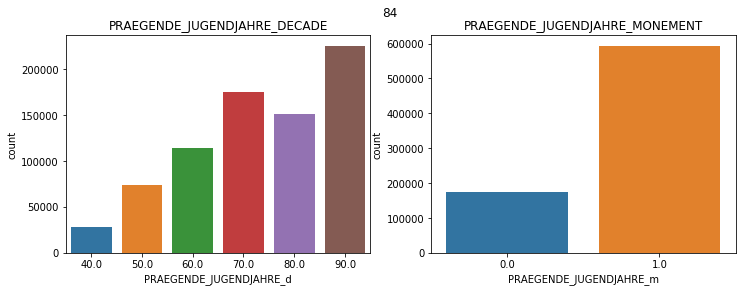

In [81]:

fig = plt.figure(14, figsize=(12,4))

ax1 = fig.add_subplot(121)
ax1.title.set_text('PRAEGENDE_JUGENDJAHRE_DECADE')
sns.countplot(azdias_new_dropf['PRAEGENDE_JUGENDJAHRE_d'])
fig.suptitle(column);           

ax2 = fig.add_subplot(122)
ax2.title.set_text('PRAEGENDE_JUGENDJAHRE_MONEMENT')
sns.countplot(azdias_new_dropf['PRAEGENDE_JUGENDJAHRE_m'])
             
fig.suptitle(column);

Two new variables have been created:
1.	PRAEGENDE_JUGENDJAHRE_DECADE: Person’s decade of youth.
•	In the new feature 90s leads followed by  70s  observations 
•	The 40s, and the  50s have the least observations.

2.	PRAEGENDE_JUGENDJAHRE_MOVEMENT: Person’s movement alignment (0: Avantgarde, 1: Mainstream )
•	In this new binary feature Mainstream leads vs. Avantgarde .


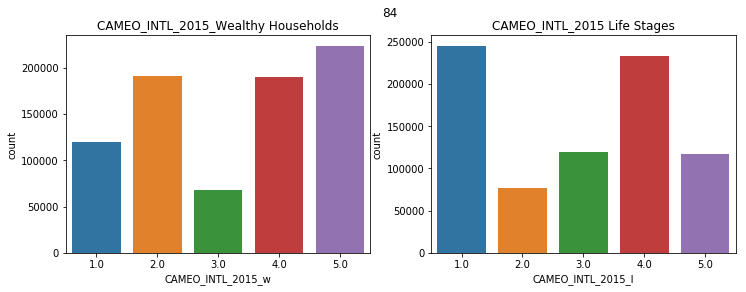

In [82]:

fig = plt.figure(14, figsize=(12,4))

ax1 = fig.add_subplot(121)
ax1.title.set_text('CAMEO_INTL_2015_Wealthy Households')
sns.countplot(azdias_new_dropf['CAMEO_INTL_2015_w'])
fig.suptitle(column);           

ax2 = fig.add_subplot(122)
ax2.title.set_text('CAMEO_INTL_2015 Life Stages')
sns.countplot(azdias_new_dropf['CAMEO_INTL_2015_l'])
             
fig.suptitle(column);

Two new variables have been engineered:
1.	CAMEO_INTL_2015 Wealthy Households:
•	In the new feature Level 5: Poorer Households leads with followed by level 4: Less Affluent Households .
•	Levels 3: Comfortable Households, and 1: Wealthy Households have the least observations 
2.	CAMEO_INTL_2015 Life Stages: Person's Life Stage 
•	In the new feature Level 1: Pre-Family Couples & Singles leads followed by level 4: Older Families & Mature Couples .
•	Levels 2: Young Couples With Children, and 3: Families With School Age Children have the least observations.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [83]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [84]:
azdias_new_dropf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797077 entries, 1 to 891220
Data columns (total 68 columns):
ALTERSKATEGORIE_GROB       794304 non-null float64
ANREDE_KZ                  797077 non-null int64
FINANZ_MINIMALIST          797077 non-null int64
FINANZ_SPARER              797077 non-null int64
FINANZ_VORSORGER           797077 non-null int64
FINANZ_ANLEGER             797077 non-null int64
FINANZ_UNAUFFAELLIGER      797077 non-null int64
FINANZ_HAUSBAUER           797077 non-null int64
GREEN_AVANTGARDE           797077 non-null int64
HEALTH_TYP                 760739 non-null float64
LP_LEBENSPHASE_FEIN        747590 non-null float64
LP_LEBENSPHASE_GROB        750398 non-null float64
RETOURTYP_BK_S             792445 non-null float64
SEMIO_SOZ                  797077 non-null int64
SEMIO_FAM                  797077 non-null int64
SEMIO_REL                  797077 non-null int64
SEMIO_MAT                  797077 non-null int64
SEMIO_VERT                 797077 non-null int

### The column OST_WEST_KZ need to be converted from object to numeric

### 3.6. OST_WEST_KZ
Building location via former East / West Germany (GDR / FRG)
- -1: unknown
-  O: East (GDR)
-  W: West (FRG)


In [85]:
azdias_new_dropf_2 = azdias_new_dropf

In [86]:
azdias_new_dropf_2['OST_WEST_KZ'] = azdias_new_dropf['OST_WEST_KZ'].replace({'O': 0, 'W': 1})

In [87]:
azdias_new_dropf_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797077 entries, 1 to 891220
Data columns (total 68 columns):
ALTERSKATEGORIE_GROB       794304 non-null float64
ANREDE_KZ                  797077 non-null int64
FINANZ_MINIMALIST          797077 non-null int64
FINANZ_SPARER              797077 non-null int64
FINANZ_VORSORGER           797077 non-null int64
FINANZ_ANLEGER             797077 non-null int64
FINANZ_UNAUFFAELLIGER      797077 non-null int64
FINANZ_HAUSBAUER           797077 non-null int64
GREEN_AVANTGARDE           797077 non-null int64
HEALTH_TYP                 760739 non-null float64
LP_LEBENSPHASE_FEIN        747590 non-null float64
LP_LEBENSPHASE_GROB        750398 non-null float64
RETOURTYP_BK_S             792445 non-null float64
SEMIO_SOZ                  797077 non-null int64
SEMIO_FAM                  797077 non-null int64
SEMIO_REL                  797077 non-null int64
SEMIO_MAT                  797077 non-null int64
SEMIO_VERT                 797077 non-null int

In [88]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Convert all data type to float64

In [89]:
df = azdias_new_dropf_2.astype(float)

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797077 entries, 1 to 891220
Data columns (total 68 columns):
ALTERSKATEGORIE_GROB       794304 non-null float64
ANREDE_KZ                  797077 non-null float64
FINANZ_MINIMALIST          797077 non-null float64
FINANZ_SPARER              797077 non-null float64
FINANZ_VORSORGER           797077 non-null float64
FINANZ_ANLEGER             797077 non-null float64
FINANZ_UNAUFFAELLIGER      797077 non-null float64
FINANZ_HAUSBAUER           797077 non-null float64
GREEN_AVANTGARDE           797077 non-null float64
HEALTH_TYP                 760739 non-null float64
LP_LEBENSPHASE_FEIN        747590 non-null float64
LP_LEBENSPHASE_GROB        750398 non-null float64
RETOURTYP_BK_S             792445 non-null float64
SEMIO_SOZ                  797077 non-null float64
SEMIO_FAM                  797077 non-null float64
SEMIO_REL                  797077 non-null float64
SEMIO_MAT                  797077 non-null float64
SEMIO_VERT            

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [91]:
def clean_data(df,df2):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    # df = convert_missingdata_encodings_to_nans(df)
    feature_info_new = feat_info
    feature_info_new['new_NaNs_status'] = feat_info['missing_or_unknown']
    feature_info_new['new_NaNs_status'] = feat_info['new_NaNs_status'].str.replace('[','')
    feature_info_new['new_NaNs_status'] = feat_info['new_NaNs_status'].str.replace(']','')
    print('Feature Info converted')
    
    # Convert missing data to NaNs
    azdias_db_new = df
    print( "Initial Shape : ", azdias_db_new.shape, 'Initial number NaNs:', azdias_db_new.isnull().sum().sum())
    for column in range(df.shape[1]):
        feature_column_4 = feature_info_new.iloc[column,4]
        feature_column_4 = feature_column_4.split(sep=',')
        feature_column_4 = [int(value) if (value != 'X' and value != 'XX' and value != '') else value for value in feature_column_4]
        if feature_column_4 != ['']:
            azdias_db_new = azdias_db_new.replace({feature_info_new.iloc[column]['attribute']: feature_column_4}, np.nan)
    print('Shape after Missing value converted into NaN : ', azdias_db_new.shape, 'new number NaNs:', azdias_db_new.isnull().sum().sum() )
    
    # remove selected columns with more NaNs than 20% ...
    # df = drop_selected_columns(df)
    azdias_db_NaNs_count = (azdias_db_new.isnull().mean() * 100).sort_values(ascending=False)
    azdias_over20 = azdias_db_NaNs_count[azdias_db_NaNs_count>20]
    azdias_db_new.drop(azdias_over20.index, axis=1, inplace=True)
    print( 'Shape after Selected columns removed NaNs >20% :', azdias_db_new.shape, 'new number NaNs:', azdias_db_new.isnull().sum().sum() )
    
    
    # remove selected rows with more NaNs than 20
    # df, df_cust_highna = drop_selected_rows(df)
    azdias_db_NaNs_row_below20 = azdias_db_new[azdias_db_new.isna().sum(axis=1)<20]
    azdias_db_new = azdias_db_new.iloc[azdias_db_NaNs_row_below20.index,:]
    print( "Shape after Selected rows removed : ", azdias_db_new.shape, 'new number NaNs:', azdias_db_new.isnull().sum().sum() )
    
    
    # select, re-encode, and engineer column values.
    # df = reencode_categorical_feat(df)
    column_list = azdias_db_new.columns.tolist()
    feat_info_new = feat_info[feat_info['attribute'].isin(column_list)]
    list_cat_column = feat_info_new[feat_info_new.type == 'categorical'].attribute
    list_multi_level_column = []
    for i in azdias_db_new[list_cat_column]:
        if  azdias_db_new[i].nunique() != 2:
            list_multi_level_column.append(i)
    
    azdias_db_new = azdias_db_new.drop(list_multi_level_column, axis = 1)   
    
    print('Re-encode, and engineer selcted categorical multilevel feat', "Shape :", azdias_db_new.shape)
    
    # df = engineer_mixed_feat(df)
    
    decade_dict = {1: 40, 2: 40, 3: 50, 4:50, 5: 60, 6: 60, 7:  60,
               8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80,
               14: 90, 15: 90,np.nan : np.nan
              }
    movement_dict = {1: 1, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0,
                8: 1, 9: 0, 10: 1, 11: 0, 12: 1, 13: 0, 14: 1, 15: 0, np.nan: np.nan
                }
    
    azdias_db_new['PRAEGENDE_JUGENDJAHRE_d'] = azdias_db_new['PRAEGENDE_JUGENDJAHRE']
    azdias_db_new['PRAEGENDE_JUGENDJAHRE_m'] = azdias_db_new['PRAEGENDE_JUGENDJAHRE']

    azdias_db_new['PRAEGENDE_JUGENDJAHRE_d'] = azdias_db_new['PRAEGENDE_JUGENDJAHRE_d'].map(decade_dict)
    azdias_db_new['PRAEGENDE_JUGENDJAHRE_m'] = azdias_db_new['PRAEGENDE_JUGENDJAHRE_m'].map(movement_dict)
    
    wealthy_households = {11:1, 12:1, 13:1, 14:1, 15:1,
                      21:2, 22:2, 23:2, 24:2, 25:2,
                      31:3, 32:3, 33:3, 34:3, 35:3,
                      41:4, 42:4, 43:4, 44:4, 45:4,
                      51:5, 52:5, 53:5, 54:5, 55:5}
    
    life_stages = {11:1, 12:2, 13:3, 14:4, 15:5,
               21:1, 22:2, 23:3, 24:4, 25:5,
               31:1, 32:2, 33:3, 34:4, 35:5,
               41:1, 42:2, 43:3, 44:4, 45:5,
               51:1, 52:2, 53:3, 54:4, 55:5}
    
    azdias_db_new['CAMEO_INTL_2015'] = pd.to_numeric(azdias_db_new['CAMEO_INTL_2015'])
    
    azdias_db_new['CAMEO_INTL_2015_w'] = azdias_db_new['CAMEO_INTL_2015'].map(wealthy_households)
    azdias_db_new['CAMEO_INTL_2015_l'] = azdias_db_new['CAMEO_INTL_2015'].map(life_stages)
    
    azdias_db_new = azdias_db_new.drop(['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE'], axis = 1)
    
    
    print('Shape after Re-encode, and engineer selcted categorical mixed feat', azdias_db_new.shape)
    
    # df = engineer_binary_feat(df)
    azdias_db_new['OST_WEST_KZ'] = azdias_db_new['OST_WEST_KZ'].replace({'O': 0, 'W': 1})
    
    print('Re-encode, and engineer selcted binary feat')
    
    # df = convert all to float
    df3 = azdias_db_new.astype(float)
    
    print('Converted all to float type')
        
    
    # Return the cleaned dataframe.
    return azdias_db_new, df3
    

In [92]:

'''A test function to test that the cleaning function 
'''
# Load in the general demographics data.
df = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep = ";")
    
# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep = ";")
print('Load the dataset, OK')
df2 = pd.DataFrame()

df, df2 = clean_data(df, df2)

print( 'Final Shape :', df.shape )
    
print('Tests Passed')

Load the dataset, OK
Feature Info converted
Initial Shape :  (891221, 85) Initial number NaNs: 4896838
Shape after Missing value converted into NaN :  (891221, 85) new number NaNs: 8373929
Shape after Selected columns removed NaNs >20% : (891221, 79) new number NaNs: 5035304
Shape after Selected rows removed :  (797077, 79) new number NaNs: 992482
Re-encode, and engineer selcted categorical multilevel feat Shape : (797077, 66)
Shape after Re-encode, and engineer selcted categorical mixed feat (797077, 68)
Re-encode, and engineer selcted binary feat
Converted all to float type
Final Shape : (797077, 68)
Tests Passed


In [93]:
df.shape

(797077, 68)

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797077 entries, 1 to 891220
Data columns (total 68 columns):
ALTERSKATEGORIE_GROB       794304 non-null float64
ANREDE_KZ                  797077 non-null int64
FINANZ_MINIMALIST          797077 non-null int64
FINANZ_SPARER              797077 non-null int64
FINANZ_VORSORGER           797077 non-null int64
FINANZ_ANLEGER             797077 non-null int64
FINANZ_UNAUFFAELLIGER      797077 non-null int64
FINANZ_HAUSBAUER           797077 non-null int64
GREEN_AVANTGARDE           797077 non-null int64
HEALTH_TYP                 760739 non-null float64
LP_LEBENSPHASE_FEIN        747590 non-null float64
LP_LEBENSPHASE_GROB        750398 non-null float64
RETOURTYP_BK_S             792445 non-null float64
SEMIO_SOZ                  797077 non-null int64
SEMIO_FAM                  797077 non-null int64
SEMIO_REL                  797077 non-null int64
SEMIO_MAT                  797077 non-null int64
SEMIO_VERT                 797077 non-null int

In [95]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797077 entries, 1 to 891220
Data columns (total 68 columns):
ALTERSKATEGORIE_GROB       794304 non-null float64
ANREDE_KZ                  797077 non-null float64
FINANZ_MINIMALIST          797077 non-null float64
FINANZ_SPARER              797077 non-null float64
FINANZ_VORSORGER           797077 non-null float64
FINANZ_ANLEGER             797077 non-null float64
FINANZ_UNAUFFAELLIGER      797077 non-null float64
FINANZ_HAUSBAUER           797077 non-null float64
GREEN_AVANTGARDE           797077 non-null float64
HEALTH_TYP                 760739 non-null float64
LP_LEBENSPHASE_FEIN        747590 non-null float64
LP_LEBENSPHASE_GROB        750398 non-null float64
RETOURTYP_BK_S             792445 non-null float64
SEMIO_SOZ                  797077 non-null float64
SEMIO_FAM                  797077 non-null float64
SEMIO_REL                  797077 non-null float64
SEMIO_MAT                  797077 non-null float64
SEMIO_VERT            

In [96]:
# Load in the general demographics data.
# df = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep = ";")


In [97]:
# Load in the general demographics data.
# df = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep = ";")


In [98]:
# Load in the feature summary file.
# feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep = ";")

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [99]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

In [100]:
# Percentage of rows with NaNs
nan_percentage = (df2.isnull().mean(axis=1) * 100).sort_values(ascending=False)
print('Total percentage of row that have NaNs : ',
    round(nan_percentage[nan_percentage > 0].shape[0]/ df2.shape[0]  * 100, 2),
      '%')

Total percentage of row that have NaNs :  21.81 %


In [101]:
# Percentage of  NaNs in total
print('Total percentage of NaNs : ',
      round(df.isnull().sum().sum() / np.product(df.shape) * 100, 2),
      '%')


Total percentage of NaNs :  1.6 %


The % of NaNs values are not hight but if we drop those columns the number is too hight, it is beter to applay imputer instead of drop them

In [102]:
# Import library
from sklearn.preprocessing import Imputer

In [103]:
# fill NaNs with the most frequent

imputer = Imputer( strategy = 'most_frequent')
matrix_value = imputer.fit_transform(df2)
df2 = pd.DataFrame(matrix_value, columns = df2.columns)

In [104]:
print(' NaNs values in the dataframe after the imputer: ', df2.isna().sum().sum())

 NaNs values in the dataframe after the imputer:  0


In [105]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_feat_scaled = scaler.fit_transform(df2)
df_feat_scaled = pd.DataFrame(df_feat_scaled, columns = df.columns)

In [106]:
df_feat_scaled.shape

(797077, 68)

In [107]:
df2.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_d,PRAEGENDE_JUGENDJAHRE_m,CAMEO_INTL_2015_w,CAMEO_INTL_2015_l
count,797077.000000,797077.000000,797077.000000,797077.000000,797077.000000,797077.000000,797077.000000,797077.000000,797077.000000,797077.000000,...,797077.000000,797077.000000,797077.000000,797077.000000,797077.000000,797077.000000,797077.000000,797077.000000,797077.000000,797077.000000
mean,2.795889,1.521377,3.058727,2.715815,3.432951,2.840685,2.656884,3.115607,0.219722,2.235834,...,1.917420,3.595612,3.370378,3.171405,5.292297,3.070929,73.911805,0.780278,3.275404,2.859124
std,1.016826,0.499543,1.377570,1.485032,1.376959,1.472527,1.399118,1.407806,0.414058,0.756382,...,1.447445,0.965521,1.097687,0.998218,2.297430,1.356907,14.641588,0.414058,1.466673,1.488052
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,40.000000,0.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,0.000000,2.000000,...,1.000000,3.000000,3.000000,3.000000,4.000000,2.000000,60.000000,1.000000,2.000000,1.000000
50%,3.000000,2.000000,3.000000,3.000000,4.000000,3.000000,2.000000,3.000000,0.000000,2.000000,...,1.000000,3.000000,3.000000,3.000000,5.000000,3.000000,80.000000,1.000000,4.000000,3.000000
75%,4.000000,2.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,0.000000,3.000000,...,3.000000,4.000000,4.000000,4.000000,7.000000,4.000000,90.000000,1.000000,5.000000,4.000000
max,4.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,3.000000,...,5.000000,5.000000,5.000000,5.000000,9.000000,5.000000,90.000000,1.000000,5.000000,5.000000


In [108]:
df_feat_scaled.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_d,PRAEGENDE_JUGENDJAHRE_m,CAMEO_INTL_2015_w,CAMEO_INTL_2015_l
count,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,...,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05
mean,-2.310333e-16,1.937178e-16,-1.709506e-16,-7.889204e-18,1.460974e-16,7.380195e-17,-1.123387e-16,-6.234700e-17,-4.245462e-17,3.788601e-17,...,1.148169e-17,-1.021050e-16,-2.972046e-17,1.876026e-16,1.284113e-16,-1.087373e-16,3.033912e-16,8.464626e-17,-7.484492e-17,3.417764e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.766173e+00,-1.043709e+00,-1.494463e+00,-1.155407e+00,-1.766903e+00,-1.250019e+00,-1.184235e+00,-1.502770e+00,-5.306541e-01,-1.633876e+00,...,-6.338204e-01,-2.688305e+00,-2.159431e+00,-2.175284e+00,-1.868305e+00,-1.526214e+00,-2.316130e+00,-1.884467e+00,-1.551406e+00,-1.249369e+00
25%,-7.827197e-01,-1.043709e+00,-7.685472e-01,-1.155407e+00,-1.040664e+00,-1.250019e+00,-1.184235e+00,-7.924445e-01,-5.306541e-01,-3.117925e-01,...,-6.338204e-01,-6.168824e-01,-3.374171e-01,-1.717112e-01,-5.624970e-01,-7.892433e-01,-9.501574e-01,5.306541e-01,-8.695902e-01,-1.249369e+00
50%,2.007334e-01,9.581212e-01,-4.263094e-02,1.913661e-01,4.118132e-01,1.081913e-01,-4.694988e-01,-8.211890e-02,-5.306541e-01,-3.117925e-01,...,-6.338204e-01,-6.168824e-01,-3.374171e-01,-1.717112e-01,-1.272278e-01,-5.227270e-02,4.158154e-01,5.306541e-01,4.940411e-01,9.467147e-02
75%,1.184186e+00,9.581212e-01,6.832853e-01,8.647525e-01,1.138052e+00,7.872963e-01,9.599741e-01,6.282067e-01,-5.306541e-01,1.010291e+00,...,7.479256e-01,4.188286e-01,5.735896e-01,8.300750e-01,7.433107e-01,6.846979e-01,1.098802e+00,5.306541e-01,1.175857e+00,7.666915e-01
max,1.184186e+00,9.581212e-01,1.409202e+00,1.538139e+00,1.138052e+00,1.466401e+00,1.674710e+00,1.338532e+00,1.884467e+00,1.010291e+00,...,2.129672e+00,1.454540e+00,1.484596e+00,1.831861e+00,1.613849e+00,1.421668e+00,1.098802e+00,5.306541e-01,1.175857e+00,1.438711e+00


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

### If we compare before and after the StandardScaler we see that before the mean and the std vary for each feature and after the mean is around zero and the std around 1

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [109]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

n_components = df_feat_scaled.shape[1] // 2
pca = PCA(n_components = n_components)
pca = pca.fit(df_feat_scaled)

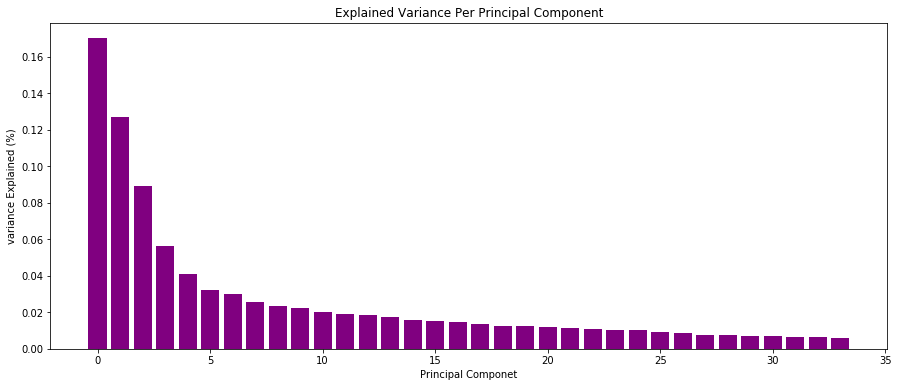

In [110]:
# Investigate the variance accounted for by each principal component.
components = np.arange(n_components)
exp_variance = pca.explained_variance_ratio_
plt.figure(figsize = (15, 6))
plt.bar(components, exp_variance, color = 'purple')
plt.xlabel('Principal Componet')
plt.ylabel('variance Explained (%)')
plt.title('Explained Variance Per Principal Component');



Text(0.5,1,'Comulative Explained Variance per Principal Component')

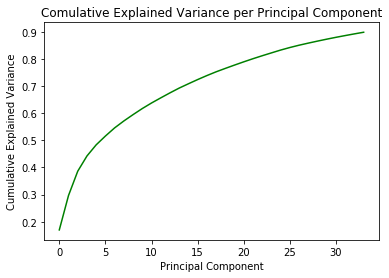

In [111]:
cum_vals = np.cumsum(exp_variance)
plt.plot(components, cum_vals, color = 'green')
plt.xlabel('Principal Component')
plt.ylabel( 'Cumulative Explained Variance')
plt.title('Comulative Explained Variance per Principal Component')

In [112]:
print ('Cumulative Explained Variance: ', pca.explained_variance_ratio_.sum())

Cumulative Explained Variance:  0.897864339018


In [113]:
# Re-apply PCA to the data while selecting for number of components to retain.
df_pca = pca.transform(df_feat_scaled)
df_pca.shape

(797077, 34)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

### This result shows that I can use around 34 features, and I still get the 89.79% of the Information. This allows us to reduce the dimensionality from 68 column to 34.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [114]:
df = pd.DataFrame(pca.components_)

In [115]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

In [116]:
"""
input
    df - Dataframe
    pca - Fitted PCA instance
    component - index of componet
    
    Return:
        dataframe: maped features to their weights in the componet
        
"""

def map_component_weights(df, pca, component):

    component_weights = pd.DataFrame(pca.components_, columns = list(df.columns)).iloc[component]
    component_weights.sort_values(ascending = False, inplace=True)
    
    return component_weights   

In [117]:
def plot_component_weghts(df, pca, component, feature_plot):
    component_weights = map_component_weights(df, pca, component)
    component_weights = pd.concat([component_weights.head(feature_plot), component_weights.tail(feature_plot)])
    
    
    component_weights.plot(kind = 'bar')
    plt.title('Component {}'.format(component+1))
    plt.ylabel('weight')
    ax = plt.gca()
    ax.grid(linewidth = '0.5', alpha = 0.5)
    ax.set_axisbelow(True)
    plt.show()
    
    return component_weights

    

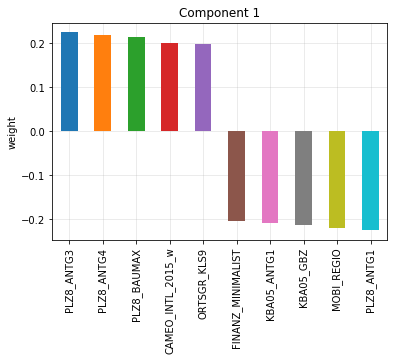

PLZ8_ANTG3           0.223967
PLZ8_ANTG4           0.217189
PLZ8_BAUMAX          0.213996
CAMEO_INTL_2015_w    0.199706
ORTSGR_KLS9          0.197287
FINANZ_MINIMALIST   -0.203997
KBA05_ANTG1         -0.208437
KBA05_GBZ           -0.211559
MOBI_REGIO          -0.219371
PLZ8_ANTG1          -0.224191
Name: 0, dtype: float64

In [118]:
component_weights = plot_component_weghts(df_feat_scaled, pca, 0, 5)
component_weights

The first component component seems to capture the population density, and financial affluence of the person

PLZ8_ANTG3, PLZ8_ANTG4 , ENG_WEALTH, HH_EINKOMMEN_SCORE, RTSGR_KLS9 and EWDICHTE have high positive weights (People that live in more densely populated areas and with lower financial affluence).

The assumption is supported by the negative weights of MOBI_REGIO , KBA05_ANTG1, PLZ8_ANTG1 and FINANZ_MINIMALIST (People that live in less densely populated areas and with higher financial affluence).

In [119]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

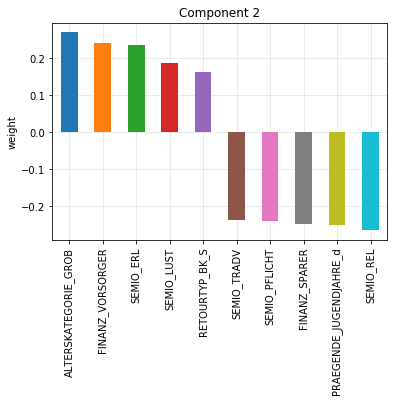

ALTERSKATEGORIE_GROB       0.269902
FINANZ_VORSORGER           0.242462
SEMIO_ERL                  0.235403
SEMIO_LUST                 0.188524
RETOURTYP_BK_S             0.163554
SEMIO_TRADV               -0.237989
SEMIO_PFLICHT             -0.239038
FINANZ_SPARER             -0.249593
PRAEGENDE_JUGENDJAHRE_d   -0.251094
SEMIO_REL                 -0.265056
Name: 1, dtype: float64

In [120]:
component_weights = plot_component_weghts(df_feat_scaled, pca, 1, 5)
component_weights

The second component seems to capture the age, generation and culture (financial, buying and other) of the person.

RETOURTYP_BK_S, SEMIO_ERL and SEMIO_LUST ALTERSKATEGORIE_GROB and FINANZ_VORSORGER have high positive weights and (older people with lower financial preparation and home ownership and less sensual and event oriented).

The assumption is supported by the negative weights of SEMIO_REL, ENG_DECADE, FINANZ_SPARER and SEMIO_TRADV (younger generation, with lower religious affinity, lower money saving, less inconspicuous and less traditional minded).

In [121]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

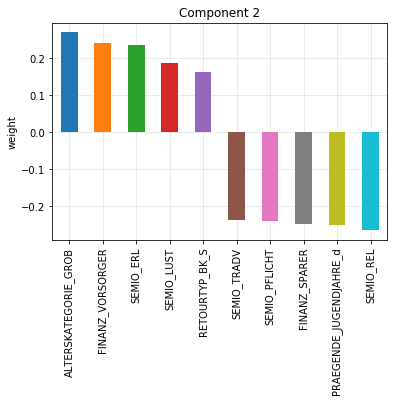

ALTERSKATEGORIE_GROB       0.269902
FINANZ_VORSORGER           0.242462
SEMIO_ERL                  0.235403
SEMIO_LUST                 0.188524
RETOURTYP_BK_S             0.163554
SEMIO_TRADV               -0.237989
SEMIO_PFLICHT             -0.239038
FINANZ_SPARER             -0.249593
PRAEGENDE_JUGENDJAHRE_d   -0.251094
SEMIO_REL                 -0.265056
Name: 1, dtype: float64

In [122]:
component_weights = plot_component_weghts(df_feat_scaled, pca, 1, 5)
component_weights

The third component seems to capture the gender and their main corresponding personality types (dreamfulness, dominance, rationality, social and family attitude) of the person.

SEMIO_VERT, SEMIO_SOZ and SEMIO_FAM, SEMIO_KULT and FINANZ_MINIMALIST and RETOURTYP_BK_S have high positive weights and in conjunction with the very strong negative weight of ANREDE_KZ can refer to (Men that are less dreamful, less socially-minded, less cultural-minded not financial minimalists and conservative return shopper types).

The assumption is supported by the negative weights of ANREDE_KZ, SEMIO_KAEM, SEMIO_DOM, SEMIO_KRIT, SEMIO_RAT and FINANZ_ANLEGER (Women that are less dominant-minded, less critical-minded, less rational have less combative attitude and are less prone to investing).

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

1.The first component component seems to capture the population density, and financial status of the person - Fig16.

PLZ8_ANTG3, PLZ8_ANTG4 , ENG_WEALTH, HH_EINKOMMEN_SCORE, RTSGR_KLS9 and EWDICHTE have high positive weights correlated with people that live in more densely populated areas and with lower financial affluence.

The assumption is supported by the negative weights of MOBI_REGIO , KBA05_ANTG1, PLZ8_ANTG1 and FINANZ_MINIMALIST correlated with People that live in less densely populated areas and with higher financial affluence.

2.The second component seems to capture the age, generation and culture (financial, buying and other) of the person - Fig17.

RETOURTYP_BK_S, SEMIO_ERL and SEMIO_LUST ALTERSKATEGORIE_GROB and FINANZ_VORSORGER have high positive weights correlated with older people with lower financial preparation and home ownership that are less sensual and event oriented.

The assumption is supported by the negative weights of SEMIO_REL, ENG_DECADE, FINANZ_SPARER and SEMIO_TRADV correlated with (younger generation, with lower religious affinity, lower money saving, less inconspicuous and less traditional minded).

3.The third component seems to capture the gender and their main corresponding personality types (dreamfulness, dominance, rationality, social and family attitude) of the person - Fig18.

SEMIO_VERT, SEMIO_SOZ and SEMIO_FAM, SEMIO_KULT and FINANZ_MINIMALIST and RETOURTYP_BK_S have high positive weights and in conjunction with the very strong negative weight of ANREDE_KZ can refer to (men that are less dreamful, less socially-minded, less cultural-minded not financial minimalists and conservative return shopper types).

The assumption is supported by the negative weights of ANREDE_KZ, SEMIO_KAEM, SEMIO_DOM, SEMIO_KRIT, SEMIO_RAT and FINANZ_ANLEGER correlated with (women that are less dominant-minded, less critical-minded, less rational, have less combative attitude and are less prone to investing).

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [123]:
from sklearn.cluster import KMeans

In [124]:
scores = []
centroids = list(range(2, 21, 2))

# Over a number of different cluster counts...
for center in centroids:

    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters = center)
    kmeans.fit(df_pca)
    
    # compute the average within-cluster distances.
    score = np.abs(kmeans.score(df_pca))
    scores.append(score)
    

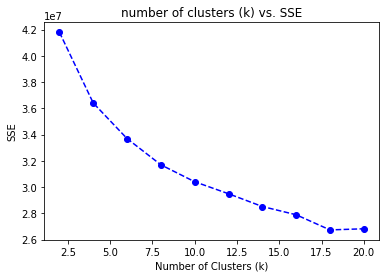

In [125]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(centroids, scores, linestyle = '--', marker = 'o', color = 'b');
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE')
plt.title('number of clusters (k) vs. SSE');
           

In [144]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 16)
kmeans = kmeans.fit(df_pca)
general_preds = kmeans.predict(df_pca)


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [127]:
# Load in the customer demographics data.
df_customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ';');


In [128]:
df_customers.shape

(191652, 85)

In [129]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 85 columns):
AGER_TYP                 191652 non-null int64
ALTERSKATEGORIE_GROB     191652 non-null int64
ANREDE_KZ                191652 non-null int64
CJT_GESAMTTYP            188439 non-null float64
FINANZ_MINIMALIST        191652 non-null int64
FINANZ_SPARER            191652 non-null int64
FINANZ_VORSORGER         191652 non-null int64
FINANZ_ANLEGER           191652 non-null int64
FINANZ_UNAUFFAELLIGER    191652 non-null int64
FINANZ_HAUSBAUER         191652 non-null int64
FINANZTYP                191652 non-null int64
GEBURTSJAHR              191652 non-null int64
GFK_URLAUBERTYP          188439 non-null float64
GREEN_AVANTGARDE         191652 non-null int64
HEALTH_TYP               191652 non-null int64
LP_LEBENSPHASE_FEIN      188439 non-null float64
LP_LEBENSPHASE_GROB      188439 non-null float64
LP_FAMILIE_FEIN          188439 non-null float64
LP_FAMILIE_GROB          188439 n

In [130]:
df_customers.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0
5,1,3,1,4.0,5,1,5,1,2,3,...,2.0,3.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0
6,2,4,1,2.0,5,1,5,1,1,2,...,3.0,2.0,1.0,0.0,1.0,5.0,5.0,2.0,3.0,2.0
7,1,4,1,2.0,5,1,5,1,2,2,...,3.0,3.0,1.0,1.0,1.0,3.0,3.0,3.0,4.0,3.0
8,2,4,2,1.0,2,2,5,1,1,5,...,1.0,4.0,2.0,1.0,5.0,5.0,4.0,3.0,8.0,3.0
9,1,3,1,3.0,5,2,4,1,3,1,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,3.0,6.0,4.0


In [131]:
def clean2_data(df,df2):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    # df = convert_missingdata_encodings_to_nans(df)
    feature_info_new = feat_info
    feature_info_new['new_NaNs_status'] = feat_info['missing_or_unknown']
    feature_info_new['new_NaNs_status'] = feat_info['new_NaNs_status'].str.replace('[','')
    feature_info_new['new_NaNs_status'] = feat_info['new_NaNs_status'].str.replace(']','')
    print('Feature Info converted')
    
    # Convert missing data to NaNs
    azdias_db_new = df
    print( "Initial Shape : ", azdias_db_new.shape, 'Initial number NaNs:', azdias_db_new.isnull().sum().sum())
    for column in range(df.shape[1]):
        feature_column_4 = feature_info_new.iloc[column,4]
        feature_column_4 = feature_column_4.split(sep=',')
        feature_column_4 = [int(value) if (value != 'X' and value != 'XX' and value != '') else value for value in feature_column_4]
        if feature_column_4 != ['']:
            azdias_db_new = azdias_db_new.replace({feature_info_new.iloc[column]['attribute']: feature_column_4}, np.nan)
    print('Shape after Missing value converted into NaN : ', azdias_db_new.shape, 'new number NaNs:', azdias_db_new.isnull().sum().sum() )
    
    # remove selected columns with more NaNs than 20% ...
    # df = drop_selected_columns(df)
    azdias_db_NaNs_count = (azdias_db_new.isnull().mean() * 100).sort_values(ascending=False)
    azdias_over20 = azdias_db_NaNs_count[azdias_db_NaNs_count>20]
    azdias_db_new.drop(azdias_over20.index, axis=1, inplace=True)
    print( 'Shape after Selected columns removed NaNs >20% :', azdias_db_new.shape, 'new number NaNs:', azdias_db_new.isnull().sum().sum() )
    
    
    # remove selected rows with more NaNs than 5
    # df, df_cust_highna = drop_selected_rows(df)
    azdias_db_NaNs_row_below20 = azdias_db_new[azdias_db_new.isna().sum(axis=1)<5]
    azdias_db_new = azdias_db_new.iloc[azdias_db_NaNs_row_below20.index,:]
    print( "Shape after Selected rows removed with NaNs >= 5: ", azdias_db_new.shape, 'new number NaNs:', azdias_db_new.isnull().sum().sum() )
    
    
    # select, re-encode, and engineer column values.
    # df = reencode_categorical_feat(df)
    column_list = azdias_db_new.columns.tolist()
    feat_info_new = feat_info[feat_info['attribute'].isin(column_list)]
    list_cat_column = feat_info_new[feat_info_new.type == 'categorical'].attribute
    list_multi_level_column = []
    for i in azdias_db_new[list_cat_column]:
        if  azdias_db_new[i].nunique() != 2:
            list_multi_level_column.append(i)
    
    azdias_db_new = azdias_db_new.drop(list_multi_level_column, axis = 1)   
    
    print('Re-encode, and engineer selcted categorical multilevel feat', "Shape :", azdias_db_new.shape)
    
    # df = engineer_binary_feat(df)
    if 'OST_WEST_KZ' in azdias_db_new.columns:
        azdias_db_new['OST_WEST_KZ'] = azdias_db_new['OST_WEST_KZ'].replace({'O': 0, 'W': 1})
        print('Re-encode, and engineer selcted binary feat')
    else:
        print('OST_WEST_KZ is not present in the dataframe')
    # df = engineer_mixed_feat(df)
    
    if 'PRAEGENDE_JUGENDJAHRE' in azdias_db_new.columns:
        decade_dict = {1: 40, 2: 40, 3: 50, 4:50, 5: 60, 6: 60, 7:  60,
                       8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80,
                       14: 90, 15: 90,np.nan : np.nan
                        }
        movement_dict = {1: 1, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0,
                         8: 1, 9: 0, 10: 1, 11: 0, 12: 1, 13: 0, 14: 1, 15: 0, np.nan: np.nan
                        }
    
        azdias_db_new['PRAEGENDE_JUGENDJAHRE_d'] = azdias_db_new['PRAEGENDE_JUGENDJAHRE']
        azdias_db_new['PRAEGENDE_JUGENDJAHRE_m'] = azdias_db_new['PRAEGENDE_JUGENDJAHRE']

        azdias_db_new['PRAEGENDE_JUGENDJAHRE_d'] = azdias_db_new['PRAEGENDE_JUGENDJAHRE_d'].map(decade_dict)
        azdias_db_new['PRAEGENDE_JUGENDJAHRE_m'] = azdias_db_new['PRAEGENDE_JUGENDJAHRE_m'].map(movement_dict)
    
        wealthy_households = {11:1, 12:1, 13:1, 14:1, 15:1,
                           21:2, 22:2, 23:2, 24:2, 25:2,
                           31:3, 32:3, 33:3, 34:3, 35:3,
                           41:4, 42:4, 43:4, 44:4, 45:4,
                           51:5, 52:5, 53:5, 54:5, 55:5}
    
        life_stages = {11:1, 12:2, 13:3, 14:4, 15:5,
                    21:1, 22:2, 23:3, 24:4, 25:5,
                    31:1, 32:2, 33:3, 34:4, 35:5,
                    41:1, 42:2, 43:3, 44:4, 45:5,
                    51:1, 52:2, 53:3, 54:4, 55:5}
        print('Shape after Re-encode, and engineer selcted categorical mixed feat', azdias_db_new.shape)
    
    else:
        print('PRAEGENDE_JUGENDJAHRE is not present in the dataframe')
    
    if 'CAMEO_INTL_2015' in azdias_db_new.columns:
        azdias_db_new['CAMEO_INTL_2015'] = pd.to_numeric(azdias_db_new['CAMEO_INTL_2015'])
    
        azdias_db_new['CAMEO_INTL_2015_w'] = azdias_db_new['CAMEO_INTL_2015'].map(wealthy_households)
        azdias_db_new['CAMEO_INTL_2015_l'] = azdias_db_new['CAMEO_INTL_2015'].map(life_stages)
    
        azdias_db_new = azdias_db_new.drop(['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE'], axis = 1)
     
        print('Shape after Re-encode, and engineer selcted categorical mixed feat', azdias_db_new.shape)
    
    else:
        print('CAMEO_INTL_2015 is not present in the dataframe')    
    
    # df = convert all to float
    df2 = azdias_db_new.astype(float)
    
    print('Converted all to float type')
        
    
    # Return the cleaned dataframe.
    return azdias_db_new, df2
    

In [132]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

'''A test function to test that the cleaning function 
'''
# Load in the general demographics data.
df_customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep = ";")
    
# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep = ";")
print('Load the dataset, OK')
df2 = pd.DataFrame()

df, df2 = clean2_data(df_customers, df2)

print( 'Final Shape :', df2.shape )
    
df_customers_cleaned = df2

print('Tests Passed')

Load the dataset, OK
Feature Info converted
Initial Shape :  (191652, 85) Initial number NaNs: 2252274
Shape after Missing value converted into NaN :  (191652, 85) new number NaNs: 3112918
Shape after Selected columns removed NaNs >20% : (191652, 32) new number NaNs: 22486
Shape after Selected rows removed with NaNs >= 5:  (188439, 32) new number NaNs: 3114
Re-encode, and engineer selcted categorical multilevel feat Shape : (188439, 26)
OST_WEST_KZ is not present in the dataframe
PRAEGENDE_JUGENDJAHRE is not present in the dataframe
CAMEO_INTL_2015 is not present in the dataframe
Converted all to float type
Final Shape : (188439, 26)
Tests Passed


In [133]:
df_customers_cleaned.shape

(188439, 26)

In [134]:
print('NaN values in the Customer data set after cleaning : ', df_customers_cleaned.isna().sum().sum())

NaN values in the Customer data set after cleaning :  3114


In [135]:
# fill NaNs with the most frequent

imputer = Imputer( strategy = 'most_frequent')
matrix_value = imputer.fit_transform(df_customers_cleaned)
df_customers_cleaned = pd.DataFrame(matrix_value, columns = df_customers_cleaned.columns)

In [136]:
print('NaN values in the Customer data set after cleaning : ', df_customers_cleaned.isna().sum().sum())

NaN values in the Customer data set after cleaning :  0


In [137]:
df_customers_cleaned.columns.shape

(26,)

In [138]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
customers_scaled = scaler.fit_transform(df_customers_cleaned)
customers_scaled = pd.DataFrame(customers_scaled, columns = df_customers_cleaned.columns)

In [145]:
customers_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,RETOURTYP_BK_S,...,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,HH_EINKOMMEN_SCORE,ONLINE_AFFINITAET
0,0.890091,-0.777558,1.004560,-0.805678,0.824872,-0.853012,-0.413652,-0.683251,1.319096,1.152396,...,-0.814301,0.204481,-1.650569,-0.824307,-2.138894,-1.707141,-1.027273,-1.578232,-1.262660,0.186149
1,0.890091,1.286078,1.004560,-0.805678,0.824872,-0.853012,0.842847,1.065159,1.319096,1.152396,...,1.512235,-1.707820,-0.889569,1.132584,0.312307,0.964298,0.311586,-1.578232,-1.262660,-1.393572
2,0.890091,-0.777558,1.004560,-0.805678,0.824872,-0.266129,-1.041901,-0.683251,-0.758095,-0.643049,...,-0.814301,0.204481,-0.128568,-0.824307,-0.913293,-0.638566,-0.357843,0.888941,0.707784,-0.603712
3,-0.045050,-0.777558,-0.926799,-0.805678,-0.178485,0.907636,1.471096,-0.683251,-0.758095,1.152396,...,-0.232667,0.841915,1.393433,-0.824307,0.312307,-1.172854,0.981016,0.888941,2.021414,1.765870
4,-0.045050,-0.777558,1.004560,-0.805678,0.824872,-0.853012,-0.413652,0.190954,1.319096,-0.643049,...,-0.232667,1.479349,-0.889569,0.154138,0.312307,-0.638566,-0.357843,0.888941,-1.262660,0.186149


In [147]:
customers_scaled.shape

(188439, 26)

In [ ]:
# Apply PCA to the data.
#from sklearn.decomposition import PCA

# n_components = customers_scaled.shape[1] // 2
#pca = PCA(n_components = n_components)
#pca = pca.fit(customers_scaled)

In [142]:
# PCA transformation
# customers_pca = pca.transform(customers_scaled)

NotFittedError: This PCA instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [143]:
# kmeans prediction
customers_preds = kmeans.predict(customers_pca)

NameError: name 'customers_pca' is not defined

In [ ]:
general_preds = kmeans.predict(df_pca)

In [146]:
# kmeans prediction
customers_preds = kmeans.predict(customers_scaled)

ValueError: Incorrect number of features. Got 26 features, expected 34

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,6))

sns.countplot(general_preds, ax = ax1)
ax1.set_title('General Cluster')
sns.countplot(customers_preds, ax = ax2)
ax2.set_title('Customer Clusters');


In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
centroid_9 = scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_center_[9]))

In [ ]:
overrepresented_c = pd.Series(data = centroid_9, index = customers_cleaned.columns)
overrepresented_c

In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

centroid_8 = scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_center_[8]))

In [ ]:
underrepresented_c = pd.Series(data = centroid_8, index = customers_cleaned.columns)
underrepresented_c

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.